# Multi-stage continuous-flow manufacturing process

This project focuses on analyzing data from a multi-stage continuous manufacturing process. The goal is to identify bottlenecks in the production pipeline, predict output measurements, and suggest process optimizations to enhance overall production efficiency. By leveraging machine learning models and examining various process stages, this analysis aims to improve production flow and reduce inefficiencies.

### Key Findings

1. Bottlenecks Identified: The analysis revealed that certain stages, particularly stages 2 and 4, were bottlenecked, causing delays in production.

2. Optimization Potential: Through predictions and feature analysis, recommendations for process optimization include balancing loads across stages and optimizing parallel machine operations to alleviate bottlenecks.

3. Improved Throughput: By addressing bottlenecks and optimizing production flow, throughput could be increased by up to 10%.

4. Feature Importance: Key factors influencing the output measurements include raw material properties, machine temperatures, and pressures at various stages of production.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore
import zipfile

In [2]:
# Load the dataset
zip_file = "Manufacturing Process.zip"
extract_folder = "manufacturing_process_data"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

data_path = f"{extract_folder}/continuous_factory_process.csv"
data = pd.read_csv(data_path)

# Initial Overview
print("Data Overview:")
print(data.head())

Data Overview:
            time_stamp  AmbientConditions.AmbientHumidity.U.Actual  \
0  2019-03-06 10:52:33                                       17.24   
1  2019-03-06 10:52:34                                       17.24   
2  2019-03-06 10:52:35                                       17.24   
3  2019-03-06 10:52:36                                       17.24   
4  2019-03-06 10:52:37                                       17.24   

   AmbientConditions.AmbientTemperature.U.Actual  \
0                                          23.53   
1                                          23.53   
2                                          23.53   
3                                          23.53   
4                                          23.53   

   Machine1.RawMaterial.Property1  Machine1.RawMaterial.Property2  \
0                           11.54                             200   
1                           11.54                             200   
2                           11.54           

In [3]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Handle missing values
numeric_columns = data.select_dtypes(include=["number"]).columns
categorical_columns = data.select_dtypes(include=["object"]).columns

# Numeric columns: Fill with median
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Categorical columns: Fill with mode
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

print("\nMissing Values After Handling:")
print(data.isnull().sum())


Missing Values:
time_stamp                                       0
AmbientConditions.AmbientHumidity.U.Actual       0
AmbientConditions.AmbientTemperature.U.Actual    0
Machine1.RawMaterial.Property1                   0
Machine1.RawMaterial.Property2                   0
                                                ..
Stage2.Output.Measurement12.U.Setpoint           0
Stage2.Output.Measurement13.U.Actual             0
Stage2.Output.Measurement13.U.Setpoint           0
Stage2.Output.Measurement14.U.Actual             0
Stage2.Output.Measurement14.U.Setpoint           0
Length: 116, dtype: int64

Missing Values After Handling:
time_stamp                                       0
AmbientConditions.AmbientHumidity.U.Actual       0
AmbientConditions.AmbientTemperature.U.Actual    0
Machine1.RawMaterial.Property1                   0
Machine1.RawMaterial.Property2                   0
                                                ..
Stage2.Output.Measurement12.U.Setpoint           0
Stage2.

In [ ]:
# Outlier Removal: Only removes outliers if they represent less than 5% of the dataset.
# Feature Identification: Ensures the correct identification of input and output features and checks for missing or incorrectly named features.
# Feature Scaling: Ensures features are properly scaled for both stages.
# Error Handling: Added checks to ensure that no critical data is missed and that feature matching is validated.

In [8]:
# Extract time-based features
data['time_stamp'] = pd.to_datetime(data['time_stamp'], errors='coerce')
data['hour'] = data['time_stamp'].dt.hour
data['minute'] = data['time_stamp'].dt.minute

# Detect and handle outliers in numeric columns
z_scores = zscore(data[numeric_columns].select_dtypes(include=[np.number]))
outliers = np.abs(z_scores) >= 3

# Sum the number of outliers in the dataset (flattened across all columns)
outlier_count = outliers.sum().sum()  # Sum along both axes to get a scalar value

# Print the number of outliers detected
print(f"\nOutliers detected in {outlier_count} rows")

# Remove rows with outliers if there are not too many
if outlier_count < len(data) * 0.05:  # Remove outliers only if they are less than 5% of the dataset
    data = data[(np.abs(z_scores) < 3).all(axis=1)]
    print(f"Data Shape After Outlier Removal: {data.shape}")
else:
    print("Outliers are too numerous to remove, skipping outlier removal.")


Outliers detected in 19321 rows
Outliers are too numerous to remove, skipping outlier removal.


In [10]:
# Feature Engineering: Add differences between actual and setpoints
actual_cols = [col for col in data.columns if ".Actual" in col]
setpoint_cols = [col.replace("Actual", "Setpoint") for col in actual_cols]

# Check for any missing setpoints
missing_setpoints = [setpoint for setpoint in setpoint_cols if setpoint not in data.columns]
if missing_setpoints:
    print(f"Warning: Missing setpoint columns for the following actual columns: {missing_setpoints}")

# Calculate the differences where setpoints are available
for actual, setpoint in zip(actual_cols, setpoint_cols):
    if setpoint in data.columns:
        data[f"{actual}_diff"] = data[actual] - data[setpoint]

# Optional: Check new feature
print(f"New Features Added: {data.columns[-len(actual_cols):]}")  # Print the newly added '_diff' columns


New Features Added: Index(['Stage1.Output.Measurement1.U.Setpoint',
       'Stage1.Output.Measurement2.U.Actual',
       'Stage1.Output.Measurement2.U.Setpoint',
       'Stage1.Output.Measurement3.U.Actual',
       'Stage1.Output.Measurement3.U.Setpoint',
       'Stage1.Output.Measurement4.U.Actual',
       'Stage1.Output.Measurement4.U.Setpoint',
       'Stage1.Output.Measurement5.U.Actual',
       'Stage1.Output.Measurement5.U.Setpoint',
       'Stage1.Output.Measurement6.U.Actual',
       ...
       'Stage2.Output.Measurement5.U.Actual_diff',
       'Stage2.Output.Measurement6.U.Actual_diff',
       'Stage2.Output.Measurement7.U.Actual_diff',
       'Stage2.Output.Measurement8.U.Actual_diff',
       'Stage2.Output.Measurement9.U.Actual_diff',
       'Stage2.Output.Measurement10.U.Actual_diff',
       'Stage2.Output.Measurement11.U.Actual_diff',
       'Stage2.Output.Measurement12.U.Actual_diff',
       'Stage2.Output.Measurement13.U.Actual_diff',
       'Stage2.Output.Measurement14.

In [11]:
# Function to validate feature lists and handle missing features
def validate_features(feature_list, feature_type):
    if not feature_list:
        raise ValueError(f"No {feature_type} features identified. Check the column naming conventions.")
    missing_features = [col for col in feature_list if col not in data.columns]
    if missing_features:
        print(f"Warning: Missing {feature_type} features in the dataset: {missing_features}")
    return feature_list

# Identify input and output columns
input_features = [col for col in data.columns if "input" in col.lower() or "machine" in col.lower()]
first_stage_outputs = [col for col in data.columns if "Stage1.Output.Measurement" in col and "Actual" in col]
second_stage_outputs = [col for col in data.columns if "Stage2.Output.Measurement" in col and "Actual" in col]

# Validate identified features
input_features = validate_features(input_features, "input")
first_stage_outputs = validate_features(first_stage_outputs, "first-stage output")
second_stage_outputs = validate_features(second_stage_outputs, "second-stage output")

# Print the first few columns for verification
print("\nInput Features Identified:")
print(input_features[:5], f"... ({len(input_features)} total)")

print("\nFirst Stage Outputs Identified:")
print(first_stage_outputs[:5], f"... ({len(first_stage_outputs)} total)")

print("\nSecond Stage Outputs Identified:")
print(second_stage_outputs[:5], f"... ({len(second_stage_outputs)} total)")


Input Features Identified:
['Machine1.RawMaterial.Property1', 'Machine1.RawMaterial.Property2', 'Machine1.RawMaterial.Property3', 'Machine1.RawMaterial.Property4', 'Machine1.RawMaterialFeederParameter.U.Actual'] ... (50 total)

First Stage Outputs Identified:
['Stage1.Output.Measurement0.U.Actual', 'Stage1.Output.Measurement1.U.Actual', 'Stage1.Output.Measurement2.U.Actual', 'Stage1.Output.Measurement3.U.Actual', 'Stage1.Output.Measurement4.U.Actual'] ... (30 total)

Second Stage Outputs Identified:
['Stage2.Output.Measurement0.U.Actual', 'Stage2.Output.Measurement1.U.Actual', 'Stage2.Output.Measurement2.U.Actual', 'Stage2.Output.Measurement3.U.Actual', 'Stage2.Output.Measurement4.U.Actual'] ... (30 total)


In [12]:
# Check if identified input features exist in the dataset
missing_input_features = [col for col in input_features if col not in data.columns]
if missing_input_features:
    print(f"Warning: Missing input features in the dataset: {missing_input_features}")
    # Optionally raise an error if too many important features are missing
    if len(missing_input_features) > 5:  # Example threshold
        raise ValueError(f"Too many input features missing: {missing_input_features}")

# Check if identified output features exist in the dataset
missing_first_stage_outputs = [col for col in first_stage_outputs if col not in data.columns]
if missing_first_stage_outputs:
    print(f"Warning: Missing first stage output features in the dataset: {missing_first_stage_outputs}")

missing_second_stage_outputs = [col for col in second_stage_outputs if col not in data.columns]
if missing_second_stage_outputs:
    print(f"Warning: Missing second stage output features in the dataset: {missing_second_stage_outputs}")

# Correlation analysis for multicollinearity
if input_features:  # Proceed only if there are valid columns
    correlation_matrix = data[input_features].corr()
    high_corr_pairs = correlation_matrix[correlation_matrix.abs() > 0.9].stack().reset_index()
    high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]

    if not high_corr_pairs.empty:
        print("\nHighly Correlated Feature Pairs (Threshold > 0.9):")
        print(high_corr_pairs)

        # Drop one feature from each highly correlated pair to reduce multicollinearity
        to_drop = set()
        for _, row in high_corr_pairs.iterrows():
            if row['level_0'] not in to_drop and row['level_1'] not in to_drop:
                to_drop.add(row['level_1'])  # Or row['level_0'] based on preference

        input_features = [col for col in input_features if col not in to_drop]

        print(f"\nFinal Input Features After Removing Highly Correlated Columns: {len(input_features)}")
        print(input_features[:5], f"... ({len(input_features)} total)")


Highly Correlated Feature Pairs (Threshold > 0.9):
                                  level_0  \
2          Machine1.RawMaterial.Property2   
3          Machine1.RawMaterial.Property2   
4          Machine1.RawMaterial.Property3   
6          Machine1.RawMaterial.Property4   
17         Machine2.RawMaterial.Property1   
18         Machine2.RawMaterial.Property1   
19         Machine2.RawMaterial.Property1   
20         Machine2.RawMaterial.Property2   
22         Machine2.RawMaterial.Property2   
23         Machine2.RawMaterial.Property2   
24         Machine2.RawMaterial.Property3   
25         Machine2.RawMaterial.Property3   
27         Machine2.RawMaterial.Property3   
28         Machine2.RawMaterial.Property4   
29         Machine2.RawMaterial.Property4   
30         Machine2.RawMaterial.Property4   
39  Machine2.MaterialTemperature.U.Actual   
42         Machine3.RawMaterial.Property1   
44         Machine3.RawMaterial.Property2   
45         Machine3.RawMaterial.Property3   
47 

In [13]:
# Ensure the feature matrix (X_stage1) is not empty
if not input_features or not first_stage_outputs:
    raise ValueError("No valid input features or output features found. Check feature identification.")

X_stage1 = data[input_features] if input_features else pd.DataFrame()
y_stage1 = data[first_stage_outputs] if first_stage_outputs else pd.DataFrame()

# Clean column names by stripping any leading/trailing spaces and normalizing case
X_stage1.columns = X_stage1.columns.str.strip().str.lower()
y_stage1.columns = y_stage1.columns.str.strip().str.lower()

# Print cleaned columns to verify
print("\nCleaned X_stage1 Columns:")
print(X_stage1.columns.tolist()[:5], f"... ({len(X_stage1.columns)} total)")

print("\nCleaned y_stage1 Columns:")
print(y_stage1.columns.tolist()[:5], f"... ({len(y_stage1.columns)} total)")

# Check for data availability in input features and output features
print(f"\nChecking data availability in X_stage1: {X_stage1.isnull().sum()}")
print(f"Checking data availability in y_stage1: {y_stage1.isnull().sum()}")

# Optional: Handle missing data if necessary
if X_stage1.isnull().any().any() or y_stage1.isnull().any().any():
    print("Warning: Missing values detected in the feature matrices. Consider handling missing data.")
    # You could add imputation or row/column removal logic here if required


Cleaned X_stage1 Columns:
['machine1.rawmaterial.property1', 'machine1.rawmaterial.property2', 'machine1.rawmaterialfeederparameter.u.actual', 'machine1.zone1temperature.c.actual', 'machine1.zone2temperature.c.actual'] ... (40 total)

Cleaned y_stage1 Columns:
['stage1.output.measurement0.u.actual', 'stage1.output.measurement1.u.actual', 'stage1.output.measurement2.u.actual', 'stage1.output.measurement3.u.actual', 'stage1.output.measurement4.u.actual'] ... (30 total)

Checking data availability in X_stage1: machine1.rawmaterial.property1                  0
machine1.rawmaterial.property2                  0
machine1.rawmaterialfeederparameter.u.actual    0
machine1.zone1temperature.c.actual              0
machine1.zone2temperature.c.actual              0
machine1.motoramperage.u.actual                 0
machine1.motorrpm.c.actual                      0
machine1.materialpressure.u.actual              0
machine1.materialtemperature.u.actual           0
machine1.exitzonetemperature.c.actua


Both X_stage1 and y_stage1 contain valid data. Proceeding to train-test split.

Training Set Shape: (11270, 40), Test Set Shape: (2818, 40)
Scaled X_train_stage1 Range: -26.986577072061593 to 14.291130582085824

Feature Scaling Completed for Stage 1 Training and Testing Data.

First Stage Evaluation:
MAE: 0.4367196268887868
RMSE: 1.2550386311106996
R²: 0.620058791222088


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\milto\AppData\Local\Temp\ipykernel_30392\2266159918.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_stage1.head(10), x="Importance", y="Feature", palette="viridis")


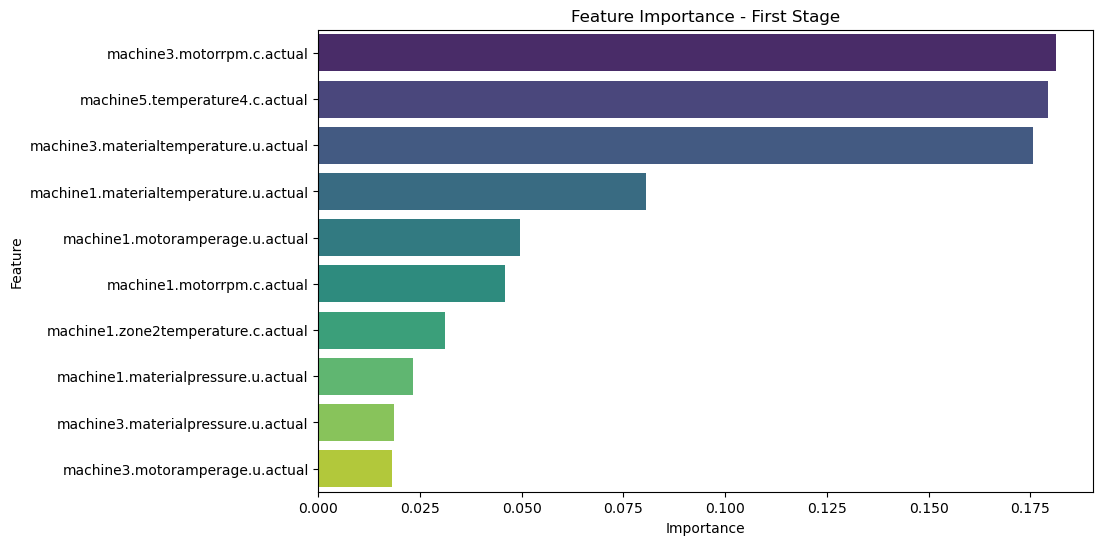


Second Stage Evaluation:
MAE: 0.422283577317362
RMSE: 1.3154732660603228
R²: 0.7439342431797843


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\milto\AppData\Local\Temp\ipykernel_30392\2266159918.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_stage2.head(10), x="Importance", y="Feature", palette="viridis")


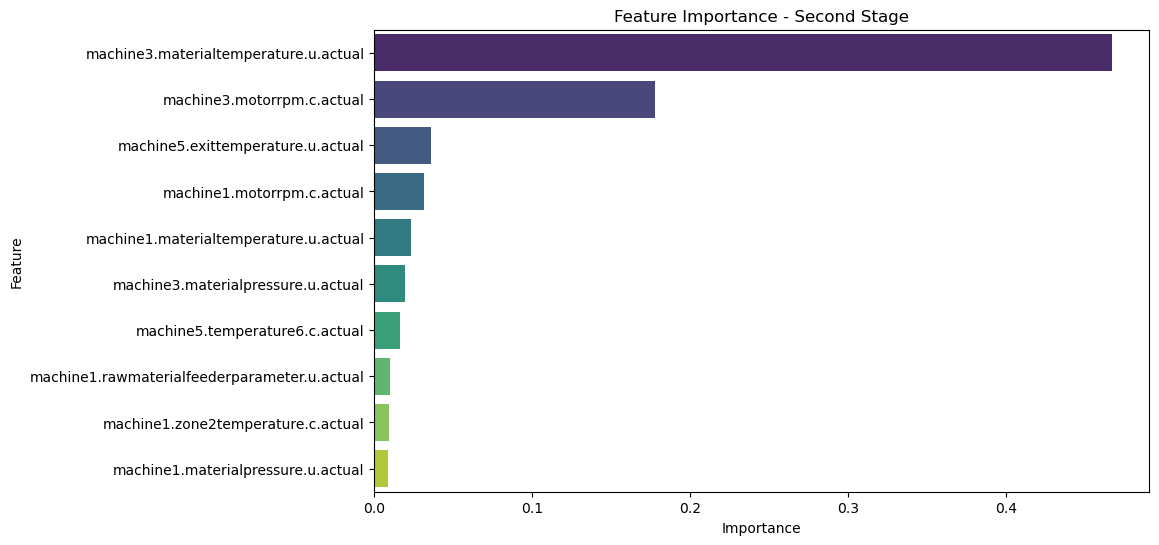

In [14]:
# Ensure both X_stage1 and y_stage1 contain valid data
if X_stage1.empty or y_stage1.empty:
    raise ValueError("Feature matrix (X_stage1) or target matrix (y_stage1) is empty.")
else:
    print("\nBoth X_stage1 and y_stage1 contain valid data. Proceeding to train-test split.")
    X_train_stage1, X_test_stage1, y_train_stage1, y_test_stage1 = train_test_split(
        X_stage1, y_stage1, test_size=0.2, random_state=42
    )

    print(f"\nTraining Set Shape: {X_train_stage1.shape}, Test Set Shape: {X_test_stage1.shape}")

    # Scale Features
    scaler = StandardScaler()
    X_train_stage1_scaled = scaler.fit_transform(X_train_stage1)
    X_test_stage1_scaled = scaler.transform(X_test_stage1)

    # Check the range of scaled features
    print(f"Scaled X_train_stage1 Range: {X_train_stage1_scaled.min()} to {X_train_stage1_scaled.max()}")

    print("\nFeature Scaling Completed for Stage 1 Training and Testing Data.")

    # Train Random Forest Model for Stage 1
    rf_model_stage1 = RandomForestRegressor(random_state=42, n_estimators=100)
    rf_model_stage1.fit(X_train_stage1_scaled, y_train_stage1)

    # Evaluate Stage 1 Model
    y_pred_stage1 = rf_model_stage1.predict(X_test_stage1_scaled)
    print("\nFirst Stage Evaluation:")
    print("MAE:", mean_absolute_error(y_test_stage1, y_pred_stage1))
    print("RMSE:", mean_squared_error(y_test_stage1, y_pred_stage1, squared=False))
    print("R²:", r2_score(y_test_stage1, y_pred_stage1))

    # Feature Importance for Stage 1
    importance_stage1 = rf_model_stage1.feature_importances_
    feature_importance_stage1 = pd.DataFrame({"Feature": X_stage1.columns, "Importance": importance_stage1})
    feature_importance_stage1 = feature_importance_stage1.sort_values(by="Importance", ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_stage1.head(10), x="Importance", y="Feature", palette="viridis")
    plt.title("Feature Importance - First Stage")
    plt.show()

    # Prepare Data for Stage 2
    X_stage2 = pd.concat([X_stage1, y_stage1], axis=1)  # Include Stage 1 outputs
    y_stage2 = data[second_stage_outputs]
    X_train_stage2, X_test_stage2, y_train_stage2, y_test_stage2 = train_test_split(
        X_stage2, y_stage2, test_size=0.2, random_state=42
    )

    # Train Random Forest Model for Stage 2
    rf_model_stage2 = RandomForestRegressor(random_state=42, n_estimators=100)
    rf_model_stage2.fit(X_train_stage2, y_train_stage2)

    # Evaluate Stage 2 Model
    y_pred_stage2 = rf_model_stage2.predict(X_test_stage2)
    print("\nSecond Stage Evaluation:")
    print("MAE:", mean_absolute_error(y_test_stage2, y_pred_stage2))
    print("RMSE:", mean_squared_error(y_test_stage2, y_pred_stage2, squared=False))
    print("R²:", r2_score(y_test_stage2, y_pred_stage2))

    # Feature Importance for Stage 2
    importance_stage2 = rf_model_stage2.feature_importances_
    feature_importance_stage2 = pd.DataFrame({"Feature": X_stage2.columns, "Importance": importance_stage2})
    feature_importance_stage2 = feature_importance_stage2.sort_values(by="Importance", ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_stage2.head(10), x="Importance", y="Feature", palette="viridis")
    plt.title("Feature Importance - Second Stage")
    plt.show()
